In [1]:
import csaps
import math
import numpy as np
import os
import pickle

from distinctipy import distinctipy
from matplotlib import animation, pyplot as plt
from ripser import ripser  # Requires Numpy >= 1.22 ('pip install numpy==1.22')
from tifffile import imread, imshow

In [2]:
### PARAMETERS ###

# We only include critical points below max_height
# Already computed for:
# 5000000 (too low)
# 10000000
# 15000000 (best so far)
# 20000000 (too high)
max_height = 15000000

# Number of regions of the river
number_of_regions = 5

In [3]:
dataset = imread("Braided River/detrended.tiff")

# Min and max height value in dataset
min_value = 3928808
max_value = 21311037

# Width and length of the river
river_width = len(dataset[0])
river_length = len(dataset[0][0])

# Distinct colors for the regions
region_colors = distinctipy.get_colors(number_of_regions, rng=1)

<IPython.core.display.Javascript object>


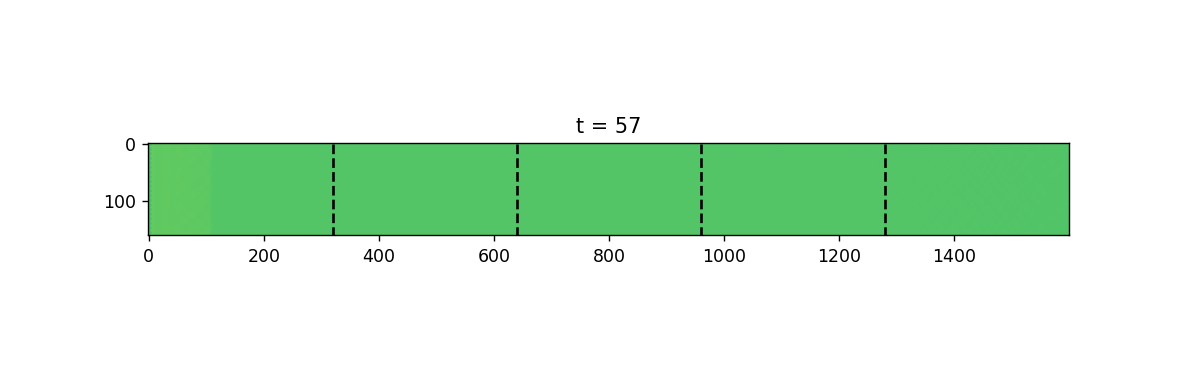

In [4]:
# Basic animation

%matplotlib notebook
%matplotlib notebook

plt.close()

fig = plt.figure("Animation of river bed elevation over time", figsize=(9.5, 3))

img = plt.imshow(dataset[0], vmin=min_value, vmax=max_value)

for i in range(1, number_of_regions):
    x = i * river_length/number_of_regions
    line = plt.plot([x, x], [0, river_width-1], c='black', linestyle='dashed')

def animate(t):
    img.set_data(dataset[t])
    
    plt.title(f"t = {t}")
    
    return img

basic_animation = animation.FuncAnimation(fig, animate, frames=len(dataset), interval=10)

# Save animation as GIF
#basic_animation.save("Animations/basic_animation.gif", writer=animation.PillowWriter(fps=20))

In [5]:
# Computes point set below max_height at time t
def compute_point_set(t, max_height, include_local_minima, include_saddles):
    if not include_local_minima and not include_saddles:
        return []
    
    print(f"t = {t}/{len(dataset) - 1}")
    
    points = []
    height_map = dataset[t]
    
    for i in range(1, len(dataset[t]) - 1):
        for j in range(1, len(dataset[t][i]) - 1):
            height = height_map[i][j]
            
            if height <= max_height:
                if include_local_minima:
                    # Check if the point (i, j) is a local minimum
                    if (
                        height < height_map[i - 1][j - 1] and height < height_map[i - 1][j] and height < height_map[i - 1][j + 1] and
                        height < height_map[i][j - 1] and height < height_map[i - 1][j + 1] and
                        height < height_map[i + 1][j - 1] and height < height_map[i + 1][j] and height < height_map[i + 1][j + 1]
                    ):
                        points.append([i, j])
                        continue
                        
                if include_saddles:
                    # Check if the point (i, j) is a saddle
                    ascent = True
                    negative_directions = 0

                    cyclic_directions = [[i - 1, j - 1], [i - 1, j], [i - 1, j + 1], [i, j + 1], [i + 1, j + 1], [i + 1, j], [i + 1, j - 1], [i, j - 1]]

                    for direction in cyclic_directions:
                        if height > height_map[direction[0]][direction[1]]:
                            if ascent:
                                ascent = False
                                negative_directions += 1
                        else:
                            ascent = True

                    if negative_directions >= 2:
                        points.append([i, j])
                    
    return points

In [6]:
file_name = f"point_sets_with_max_height_{max_height}"

# If point sets not yet computed for this max_height, compute them (takes long)
if not os.path.exists(f"Point data/{file_name}.data"):
    point_sets_per_timestep = [compute_point_set(t, max_height, True, False) for t in range(len(dataset))]
    
    with open(f"Point data/{file_name}.data", "wb") as f:
        pickle.dump(point_sets_per_timestep, f)
        
# If point sets already computed for this max_height, quickly retrieve them
else:
    with open(f"Point data/{file_name}.data", "rb") as f:
        point_sets_per_timestep = pickle.load(f)



# Compute point sets of different regions on the river
regional_point_sets_per_timestep = []

for point_set in point_sets_per_timestep:
    regional_point_sets = [[] for i in range(number_of_regions)]
    
    for p in point_set:
        region = math.floor(p[1] / (river_length / number_of_regions))
        regional_point_sets[region].append(p)
            
    regional_point_sets_per_timestep.append(regional_point_sets)

<IPython.core.display.Javascript object>


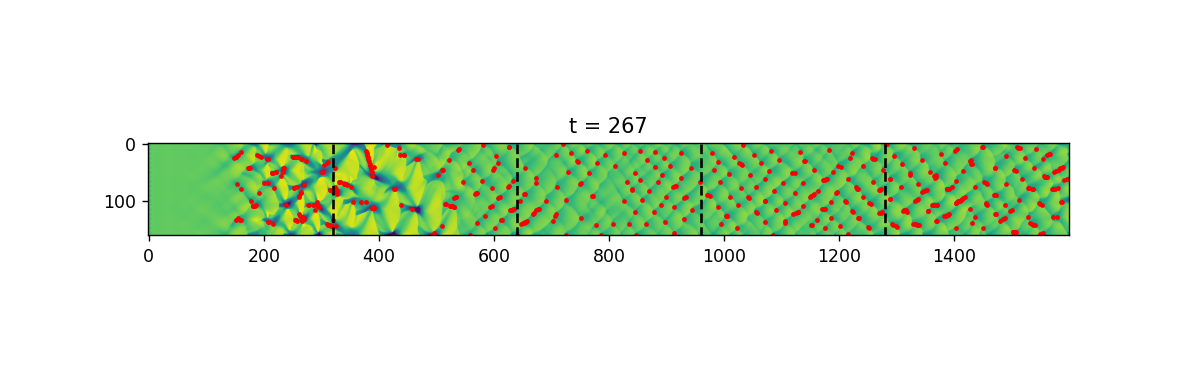

In [7]:
# Animation with low local minima highlighted

%matplotlib notebook
%matplotlib notebook

plt.close()

fig = plt.figure(f"Animation of river bed elevation and local minima lower than {max_height} over time", figsize=(9.5, 3))

img = plt.imshow(dataset[0], vmin=min_value, vmax=max_value)
scat = plt.scatter(x=[], y=[])

for i in range(1, number_of_regions):
    x = i * river_length/number_of_regions
    line = plt.plot([x, x], [0, river_width-1], c='black', linestyle='dashed')

def animate(t):
    img.set_data(dataset[t])

    global scat
    scat.remove()
    scat = plt.scatter(x=[p[1] for p in point_sets_per_timestep[t]], y=[p[0] for p in point_sets_per_timestep[t]], c='r', s=3)

    plt.title(f"t = {t}")
    
    return img, scat

local_minima_animation = animation.FuncAnimation(fig, animate, frames=len(dataset), interval=50)

# Save animation as GIF
#local_minima_animation.save("Animations/local_minima_animation.gif", writer=animation.PillowWriter(fps=20))

In [8]:
# Computes total and regional persistence diagrams at time t
def compute_persist_diagrams(t):
    print(f"t = {t}/{len(dataset) - 1}")
    
    if point_sets_per_timestep[t]:
        first_persist_diagram = sorted(ripser(np.array(point_sets_per_timestep[t]))['dgms'][1].tolist())
    else:
        first_persist_diagram = []
    
    regional_first_persist_diagrams = []
    for regional_point_set in regional_point_sets_per_timestep[t]:
        if regional_point_set:
            regional_first_persist_diagrams.append(sorted(ripser(np.array(regional_point_set))['dgms'][1].tolist()))
        else:
            regional_first_persist_diagrams.append([])
    
    return (first_persist_diagram, regional_first_persist_diagrams)

In [9]:
file_name = f"persist_diagrams_with_max_height_{max_height}"

# If persistence diagrams not yet computed for this max_height, compute them (takes long)
if not os.path.exists(f"Persistence diagrams/{file_name}.data"):
    first_persist_diagram_per_timestep = []
    regional_first_persist_diagrams_per_timestep = []
    
    for t in range(len(dataset)):
        diagram, regional_diagrams = compute_persist_diagrams(t)
        first_persist_diagram_per_timestep.append(diagram)
        regional_first_persist_diagrams_per_timestep.append(regional_diagrams)
    
    with open(f"Persistence diagrams/{file_name}.data", "wb") as f:
        pickle.dump((first_persist_diagram_per_timestep, regional_first_persist_diagrams_per_timestep), f)
        
# If persistence diagrams already computed for this max_height, quickly retrieve them
else:
    with open(f"Persistence diagrams/{file_name}.data", "rb") as f:
        first_persist_diagram_per_timestep, regional_first_persist_diagrams_per_timestep = pickle.load(f)        



# Largest persistence diagram coordinate
max_persist_value = max([height for diagram in first_persist_diagram_per_timestep for point in diagram for height in point])

# Largest persistence diagram size
max_persist_length = max(len(sublist) for sublist in first_persist_diagram_per_timestep)  

<IPython.core.display.Javascript object>


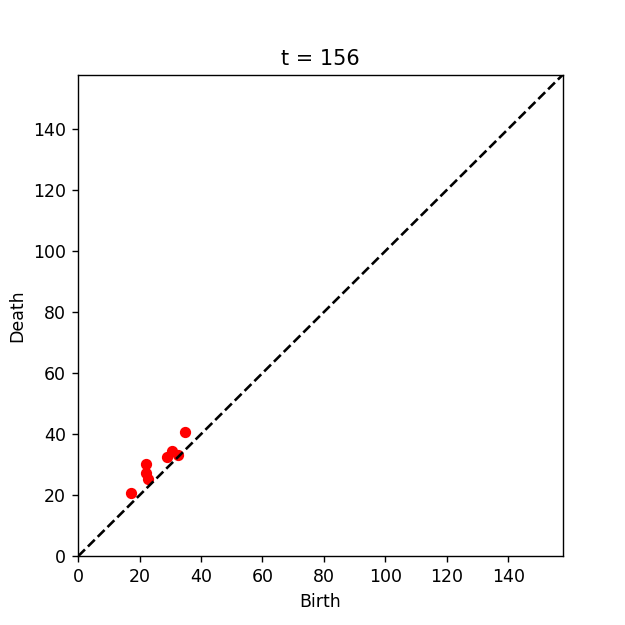

In [10]:
# Animation of 1-dimensional persistence diagram of local minima lower than max_height over time

%matplotlib notebook
%matplotlib notebook

plt.close()

fig = plt.figure(f"Animation of 1D persistence diagram over time", figsize=(5, 5))

plt.xlabel("Birth")
plt.ylabel("Death")
plt.xlim([0, max_persist_value])
plt.ylim([0, max_persist_value])

scat = plt.scatter(x=[], y=[])
diagonal = plt.plot([0, max_persist_value], [0, max_persist_value], c='black', linestyle='dashed')

def animate(t):
    first_persist_diagram = first_persist_diagram_per_timestep[t]
    
    global scat
    scat.remove()
    scat = plt.scatter(x=[p[0] for p in first_persist_diagram], y=[p[1] for p in first_persist_diagram], c='r', s=30)
        
    plt.title(f"t = {t}")
    
    return scat

persist_diagram_animation = animation.FuncAnimation(fig, animate, frames=len(dataset), interval=100)

# Save animation as GIF
#persist_diagram_animation.save("Animations/persist_diagram_animation.gif", writer=animation.PillowWriter(fps=15))

<IPython.core.display.Javascript object>


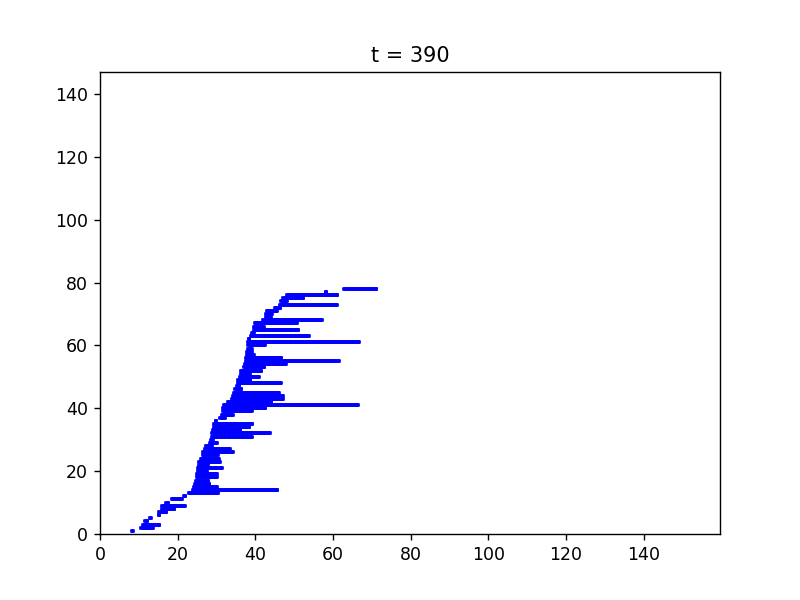

In [11]:
# Animation of 1-dimensional persistence barcodes of local minima lower than max_height over time

%matplotlib notebook
%matplotlib notebook

plt.close()

fig = plt.figure(f"Animation of 1D persistence barcodes over time")

plt.xlim([0, max_persist_value + 2])
plt.ylim([0, max_persist_length + 2])

barcode_width = 1

barcodes = []

def animate(t):
    first_persist_diagram = first_persist_diagram_per_timestep[t]
    
    global barcodes
    for b in barcodes:
        b.remove()
    barcodes = []
    
    for i in range(len(first_persist_diagram)):      
        birth = first_persist_diagram[i][0]
        death = first_persist_diagram[i][1]
        
        line = [min(birth + math.sqrt(barcode_width) * x/3, death) for x in range(math.ceil((death - birth)*3 / math.sqrt(barcode_width) + 1))]
        barcodes.append(plt.scatter(line, [i + 1] * len(line), c='b', marker='s', s=barcode_width))
        
    plt.title(f"t = {t}")
    
    return barcodes

persist_barcodes_animation = animation.FuncAnimation(fig, animate, frames=len(dataset), interval=100)

# Save animation as GIF
#persist_barcodes_animation.save("Animations/persist_barcodes_animation.gif", writer=animation.PillowWriter(fps=15))

<IPython.core.display.Javascript object>


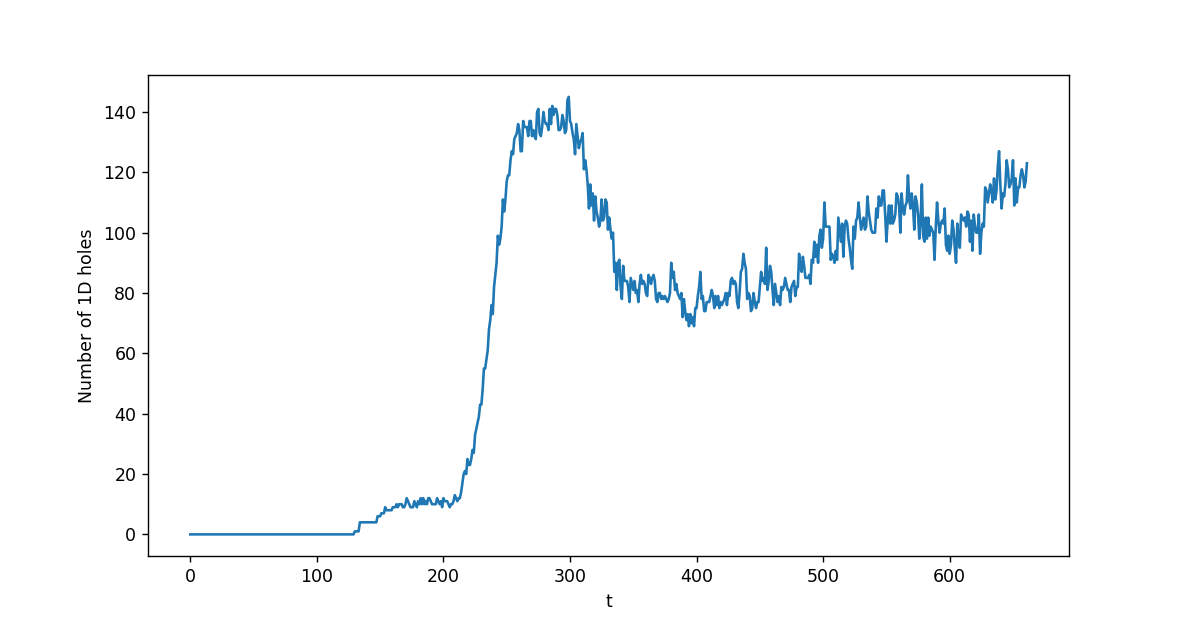

In [12]:
# Number of 1-dimensional holes over time

plt.close()

fig = plt.figure(figsize=(9.5, 5))

#plt.title("Number of 1-dimensional holes over time")
plt.xlabel("t")
plt.ylabel("Number of 1D holes")

number_of_holes_over_time = plt.plot(range(len(dataset)), [len(x) for x in first_persist_diagram_per_timestep])

# Save plot as PNG
plt.savefig("Plots/number_of_holes_over_time.png")

<IPython.core.display.Javascript object>


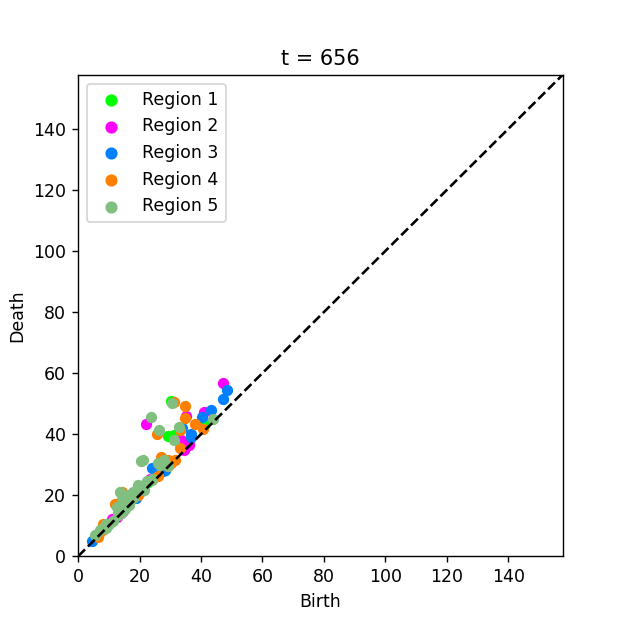

In [13]:
# Animation of 1-dimensional persistence diagram of local minima lower than max_height in different regions of the river over time

%matplotlib notebook
%matplotlib notebook

plt.close()

fig = plt.figure(f"Animation of 1D persistence diagram in different regions of the river over time", figsize=(5, 5))

plt.xlabel("Birth")
plt.ylabel("Death")
plt.xlim([0, max_persist_value])
plt.ylim([0, max_persist_value])

scats = []
for i in range(number_of_regions):
    scats.append(plt.scatter(x=[], y=[], c=np.asarray([region_colors[i]]), label=f"Region {i + 1}"))

legend = plt.legend()

diagonal = plt.plot([0, max_persist_value], [0, max_persist_value], c='black', linestyle='dashed')

def animate(t):
    regional_first_persist_diagrams = regional_first_persist_diagrams_per_timestep[t]
    
    global scats
    for scat in scats:
        scat.remove()
    scats = []
    
    for i in range(number_of_regions):
        diagram = regional_first_persist_diagrams[i]
        scats.append(plt.scatter(x=[p[0] for p in diagram], y=[p[1] for p in diagram], s=30, c=np.asarray([region_colors[i]])))#, label=f"Region {i + 1}"))
        
    plt.title(f"t = {t}")
    
    return scats

regional_persist_diagram_animation = animation.FuncAnimation(fig, animate, frames=len(dataset), interval=100)

# Save animation as GIF
#regional_persist_diagram_animation.save("Animations/regional_persist_diagram_animation.gif", writer=animation.PillowWriter(fps=20))

<IPython.core.display.Javascript object>


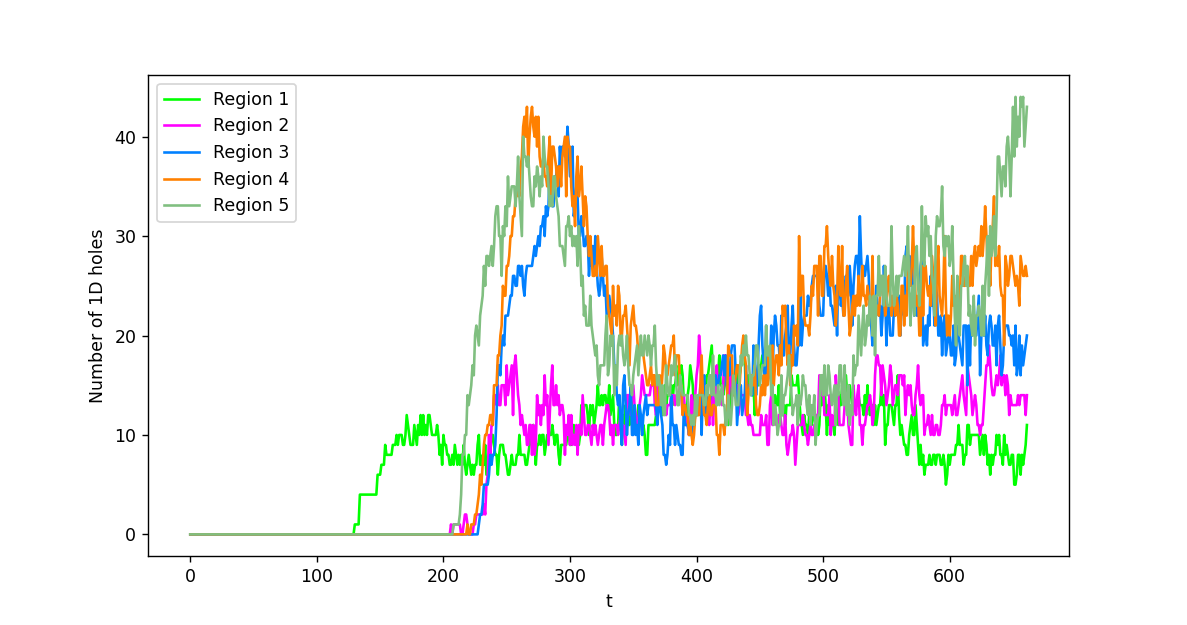

In [14]:
# Number of 1-dimensional holes in different regions of the river over time

plt.close()

fig = plt.figure(figsize=(9.5, 5))

#plt.title("Number of 1D holes per region over time")
plt.xlabel("t")
plt.ylabel("Number of 1D holes")

regional_holes = [[] for i in range(number_of_regions)]

for regional_first_persist_diagrams in regional_first_persist_diagrams_per_timestep:
    for i in range(len(regional_first_persist_diagrams)):
        regional_holes[i].append(len(regional_first_persist_diagrams[i]))
    
for i in range(len(regional_holes)):
    regional_holes_over_time = plt.plot(range(len(dataset)), regional_holes[i], c=region_colors[i], label=f"Region {i + 1}")

legend = plt.legend()

# Save plot as PNG
plt.savefig("Plots/number_of_holes_per_region_over_time.png")

<IPython.core.display.Javascript object>


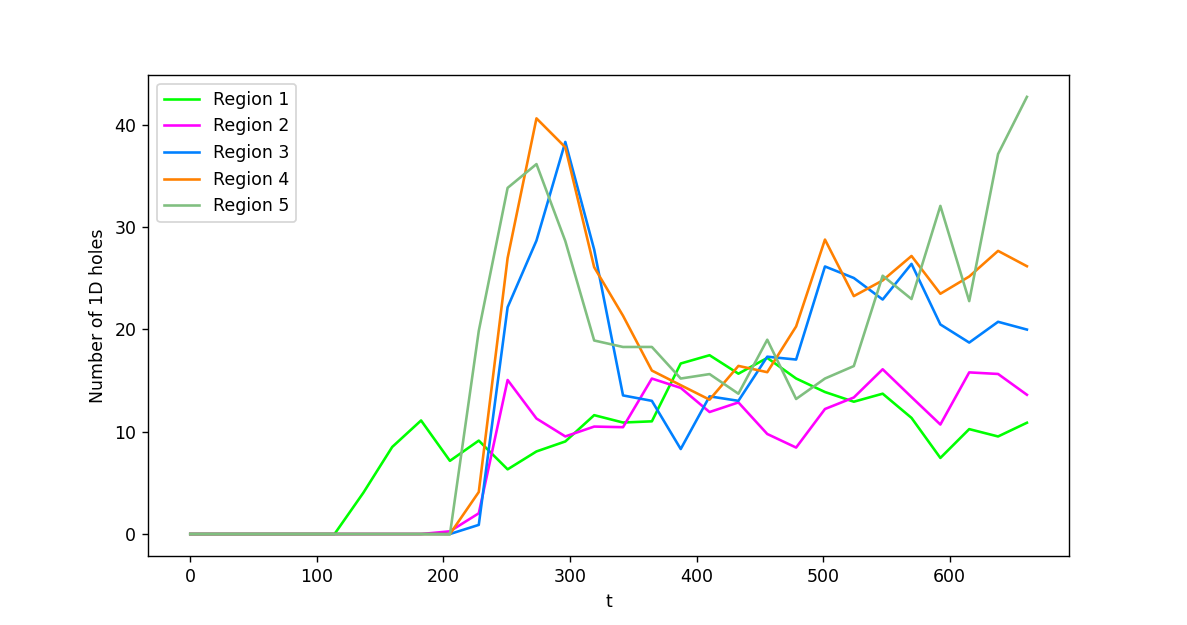

In [15]:
# Smooth splines of number of 1-dimensional holes in different regions of the river over time

plt.close()

fig = plt.figure(figsize=(9.5, 5))

#plt.title("Number of 1D holes per region over time")
plt.xlabel("t")
plt.ylabel("Number of 1D holes")

for i in range(len(regional_holes)):
    x = range(len(dataset))
    y = regional_holes[i]
    
    spline = csaps.CubicSmoothingSpline(x, y, smooth=0.85)
    
    xs = np.linspace(x[0], x[-1], 30)
    ys = spline(xs)
    
    regional_holes_over_time = plt.plot(xs, ys, c=region_colors[i], label=f"Region {i + 1}")

legend = plt.legend()

# Save plot as PNG
plt.savefig("Plots/smooth_number_of_holes_per_region_over_time.png")

<IPython.core.display.Javascript object>


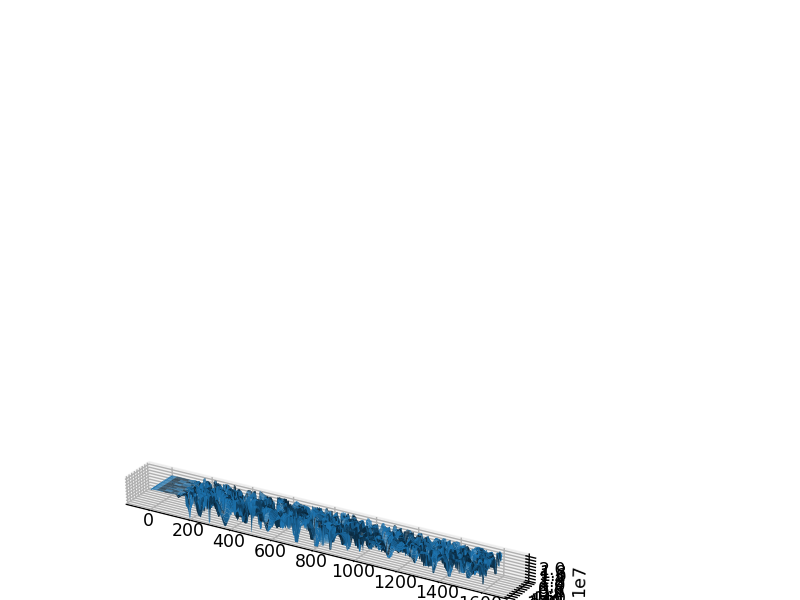

In [16]:
# 3D plot of the river

from mpl_toolkits.mplot3d import Axes3D

plt.close()

fig = plt.figure(constrained_layout=True)

x, y = np.meshgrid(range(river_length), range(river_width))

ax = fig.add_subplot(111, projection='3d')

x_scale=river_length/river_width
y_scale=1
z_scale=1

scale=np.diag([x_scale, y_scale, z_scale, 1.0])
scale=scale*(1.0/scale.max())
scale[3,3]=1.0

def short_proj():
    return np.dot(Axes3D.get_proj(ax), scale)

ax.get_proj = short_proj

terrain = ax.plot_surface(x, y, dataset[400])